# Spectral Bias in Neural Networks (1D Regression)

In this notebook, we study how a neural network learns different frequency components of a target function during training. We will show that low frequencies are learnt faster than higher ones.
This phenomenon is often referred to as **spectral bias** or **frequency bias**.

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd   # <-- to save CSV files

## 1. Dataset: A multi-frequency 1D signal

We construct a synthetic target function defined on $[0,1)$ as a superposition of three sine waves:

$$f(x) = 1.0 \sin(2\pi x) + 0.5 \sin(8\pi x) + 0.2 \sin(32\pi x)$$

As a consequence, $f$ has three frequency components:
- A **low frequency** ($k=1$), with amplitude $1.0$, wavelength $\approx 1.0$
- A **medium frequency** ($k=4$), with amplitude $0.5$, wavelength $\approx 0.25$
- A **high frequency** ($k=16$), with amplitude $0.2$, wavelength $\approx 0.0625$

In the notebook we will visually track the learnt frequency components during training.

In [18]:
# --- Create 1D dataset with multiple frequencies ---
N = 1024 # number of points in the dataset
x = np.linspace(0, 1, N, endpoint=False) # equispaced points
x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)

# target: sum of sinusoids with different frequencies
f_true = (
    np.sin(2*np.pi * x) * 1.0       # low freq
  + 0.5 * np.sin(8*np.pi * x)      # medium freq
  + 0.2 * np.sin(32*np.pi * x)     # high freq
)
y_t = torch.tensor(f_true, dtype=torch.float32).unsqueeze(1)



## 2. Neural network model

Since we are concerned with *learning behavior* rather than expressiveness, we use a small fully connected neural network with scalar input and output, two hidden layers with 64 neurons each and Tanh activation.





In [19]:
# --- Define a small DNN ---
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)


## 3. Optimization setup

We train the network using the Adam optimizer with learning rate $\alpha = 0.01$ to optimize the  Mean Squared Error (MSE) loss function over  8000 epochs.

We record the network output at selected epochs $\{100, 1500, 4000, 7500\}$ to visualize how the approximation evolves during training. These checkpoints capture:
- An **early learning** stage (epoch 100), when the network shows an  initial response to low frequencies
- An **intermediate learning** stage (epochs 1500, 4000), where moderate frequencies start to be progressively learnt
- A **late training** stage (epoch 7500), where the high-frequency components finally start to emerge

In [20]:
model = Network()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
epochs = 8000
record_epochs = [100, 1500, 4000, 7500]
outputs = {}

## 4. Training loop

We implement standard stochastic gradient descent with backpropagation.
Given training points $\{x_i,y_i\}_{i=1}^m$ and the current neural network model $h_\theta$,  the training is composed of the following phases:
1. **Forward pass**: Compute predictions $y_{\text{pred},i} = h_{\theta}(x_i)$
2. **Loss computation**: Calculate MSE $L(\theta) = \frac{1}{N}\sum_{i=1}^N (y_{\text{pred},i} - y_i)^2$
3. **Backward pass**: Compute gradients wrt $\theta$ via automatic differentiation
4. **Parameter update**: Update $\theta$ using the Adam optimizer

During training, we periodically store the predicted output at specified epochs to enable visualization of the learning progression across different frequency components.

In [21]:
# --- Training  ---

for ep in range(epochs):
    optimizer.zero_grad()
    pred = model(x_t)
    loss = loss_fn(pred, y_t)
    loss.backward()
    optimizer.step()

    if ep in record_epochs:
        with torch.no_grad():
            y_pred = model(x_t).cpu().numpy().squeeze()
        outputs[ep] = y_pred
        print("Epoch", ep, "loss", loss.item())




Epoch 100 loss 0.15378731489181519
Epoch 1500 loss 0.018730822950601578
Epoch 4000 loss 0.01056656613945961
Epoch 7500 loss 0.000996541348285973


## 5. Visualization: learning different frequencies

Each subplot shows the network prediction at a different training epochs.
Observe how the low-frequency components are learned first (at epoch 100 the network captures only the smooth envelope), while moderate frequencies gradually emerge between epoch 1500 and 4000, and
high-frequency oscillations appear much later in training (high-frequency oscillations become visible only at epoch 7500).

This visual progression directly demonstrates the **spectral bias**.

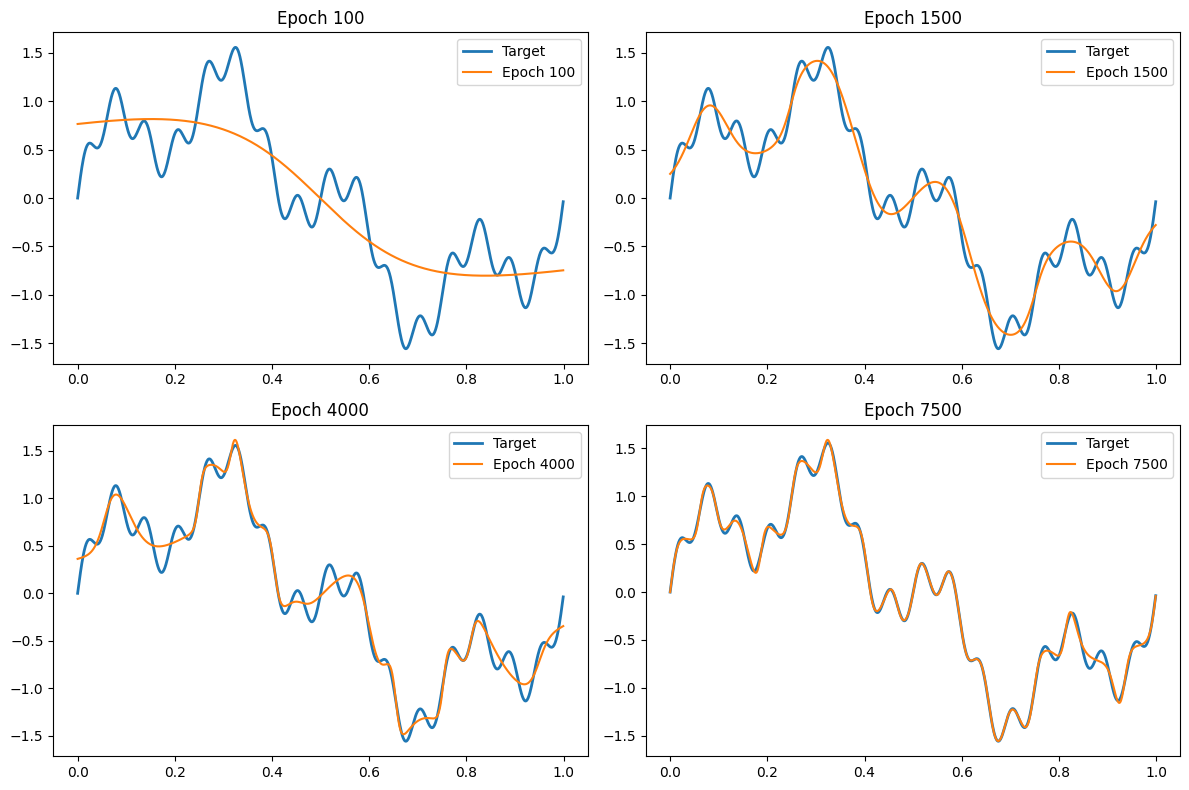

In [22]:
# ------------- plot results -------------
plt.figure(figsize=(12, 8))
for i, ep in enumerate(record_epochs):
    plt.subplot(2, 2, i+1)
    plt.plot(x, f_true, label='Target', linewidth=2)
    plt.plot(x, outputs[ep], label=f'Epoch {ep}')
    plt.legend()
    plt.title(f'Epoch {ep}')
plt.tight_layout()
plt.show()

## 6. Discussion

The spectral bias has a deep impact in SciML and specifically in the training of PINNs, since PDE solutions often contain high-frequency or localized features. Standard neural networks may struggle to learn these efficiently and understanding spectral bias is crucial for designing effective training methods.